In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [31]:
ticker = yf.Ticker("AAPL")
expiration_dates = ticker.options
exp_date = expiration_dates[4]  #1 month expiry
option_chain = ticker.option_chain(exp_date)
calls = option_chain.calls
puts = option_chain.puts
print("Calls:\n", calls.head())
print("Puts:\n", puts.tail())

Calls:
         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0  AAPL250627C00110000 2025-05-23 18:20:54+00:00   110.0      85.80  85.40   
1  AAPL250627C00140000 2025-05-23 19:26:29+00:00   140.0      56.29  55.85   
2  AAPL250627C00150000 2025-05-23 19:26:06+00:00   150.0      46.75  46.10   
3  AAPL250627C00165000 2025-05-23 15:32:16+00:00   165.0      33.52  31.90   
4  AAPL250627C00170000 2025-05-23 19:01:45+00:00   170.0      27.76  27.40   

     ask     change  percentChange  volume  openInterest  impliedVolatility  \
0  86.60 -10.849998     -11.226071     1.0             7           1.063481   
1  56.95  56.290000            NaN  7171.0             0           0.735842   
2  47.20  -7.310001     -13.522016    11.0            34           0.642093   
3  32.40 -14.660000     -30.427563     5.0             1           0.501470   
4  27.80  -6.400000     -18.735363    13.0             4           0.484991   

   inTheMoney contractSize currency  
0        T

In [44]:
#Contracts are chosen whose strikes are closer to current spot 
print(f'Chosen Call Contract: {calls['contractSymbol'].iloc[-25]} \t Strike: {calls['strike'].iloc[-25]} \t Price: {calls['lastPrice'].iloc[-25]}')
print(f'Chosen Put Contract: {puts['contractSymbol'].iloc[-10]} \t Strike: {puts['strike'].iloc[-10]} \t Price: {puts['lastPrice'].iloc[-10]}')
call_strike=int(calls['strike'].iloc[-25])
put_strike=int(puts['strike'].iloc[-10])

Chosen Call Contract: AAPL250627C00190000 	 Strike: 190.0 	 Price: 11.85
Chosen Put Contract: AAPL250627P00200000 	 Strike: 200.0 	 Price: 10.02


In [45]:
df=yf.download('AAPL',start='2024-05-24',end='2025-05-24',auto_adjust=False)
df=df.reset_index()
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index('Date')
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2024-05-24,189.095657,189.979996,190.580002,188.039993,188.820007,36294600
2024-05-28,189.105621,189.990005,193.000000,189.100006,191.509995,52280100
2024-05-29,189.404221,190.289993,192.250000,189.509995,189.610001,53068000
2024-05-30,190.399567,191.289993,192.179993,190.630005,190.759995,49947900
2024-05-31,191.355103,192.250000,192.570007,189.910004,191.440002,75158300


In [46]:
df['Returns']=df['Adj Close']/df['Adj Close'].shift(1) - 1
df = df.drop(labels='2024-05-24')
df.head()

Price,Adj Close,Close,High,Low,Open,Volume,Returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,,
2024-05-28,189.105621,189.990005,193.000000,189.100006,191.509995,52280100,0.000053
2024-05-29,189.404221,190.289993,192.250000,189.509995,189.610001,53068000,0.001579
2024-05-30,190.399567,191.289993,192.179993,190.630005,190.759995,49947900,0.005255
2024-05-31,191.355103,192.250000,192.570007,189.910004,191.440002,75158300,0.005019
2024-06-03,193.126816,194.029999,194.990005,192.520004,192.899994,50080500,0.009259


In [ ]:
temp_spot=df['Adj Close'].iloc[-1]     #Current Stock Price
spot=float(temp_spot.iloc[0])
stdev=(df['Returns'].std())*(252**0.5)  #Standard deviation of returns

In [52]:
steps=50  #Steps of Binomial Tree
T=26/252     #Time to Expiry (years)
r=0.0436    #1 month US Treasury Bill Rate (Risk free rate)
dt=T/steps  #Time Steps of binomial tree

In [53]:
u=float(np.exp(stdev*np.sqrt(dt)) )    #Up movement factor
d=1/u                   #Down movement factor
p=float((np.exp(r*dt)-d)/(u-d))   #Risk-neutral probability of up move
q=1-p           #Risk-neutral probability of down move

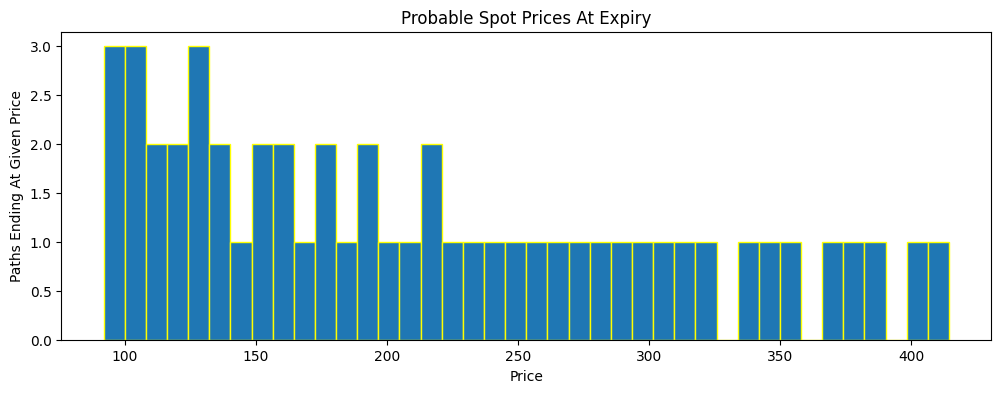

In [66]:
#Probable final spot prices at expiry
final_price=[]
for i in range(51):
    final_price.append(spot*(u**(steps-i))*(d**i))
#Plot expected spot prices 
plt.figure(figsize=(12, 4))
plt.hist(final_price,bins=40,edgecolor='yellow')
plt.xlabel("Price")
plt.ylabel('Paths Ending At Given Price')
plt.title('Probable Spot Prices At Expiry')
plt.show()

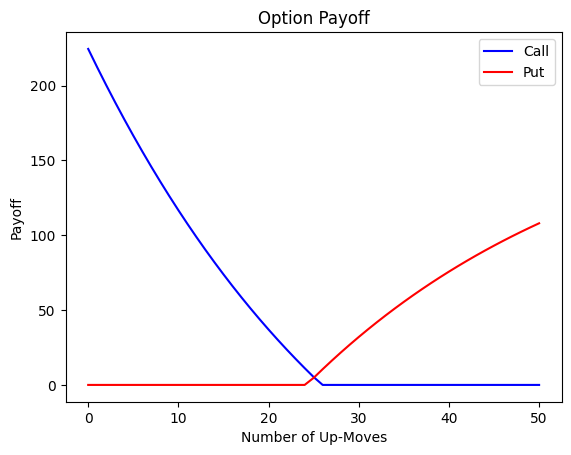

In [64]:
#Payoff at expiry for call option
call_payoff=[]
for i in range(len(final_price)):
    call_payoff.append(max((final_price[i]-call_strike),0))
#Payoff at expiry for put option
put_payoff=[]
for i in range(len(final_price)):
    put_payoff.append(max((put_strike-final_price[i]),0))
#Plot Payoffs
x = np.arange(0, steps+1)   #Number of up-moves
plt.plot(x,call_payoff,label='Call',color='blue')
plt.plot(x,put_payoff,label='Put',color='red')
plt.title('Option Payoff')
plt.xlabel('Number of Up-Moves')
plt.ylabel('Payoff')
plt.legend()
plt.show()

In [ ]:
#Back Propogation (Call Option)
bp_call=[]
for i in range(50):
    bp_call.append([])
for i in range(len(call_payoff)-1):
    bp_call[0].append(((p*call_payoff[i])+(q*call_payoff[i+1]))*2.718**(-r*dt))
for i in range(1,50):
    for j in range(len(bp_call[i-1])-1):
        bp_call[i].append(((p*bp_call[i-1][j])+(q*bp_call[i-1][j+1]))*2.718**(-r*dt))
print(f'Fair Call Price: {round(bp_call[-1][0],2)}')
#Back Propogation (Put Option)
bp_put=[]
for i in range(50):
    bp_put.append([])
for i in range(len(put_payoff)-1):
    bp_put[0].append(((p*put_payoff[i])+(q*put_payoff[i+1]))*2.718**(-r*dt))
for i in range(1,50):
    for j in range(len(bp_put[i-1])-1):
        bp_put[i].append(((p*bp_put[i-1][j])+(q*bp_put[i-1][j+1]))*2.718**(-r*dt))
print(f'Fair Put Price: {round(bp_put[-1][0],2)}')

Fair Call Price: 11.57
Fair Put Price: 10.44


Conclusion: Call option is overpriced. Put option is underpriced